In [1]:
# 라이브러리 import
# 파이썬 기본 라이브러리를 가장 위에 쓰는 것을 추천
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

from tensorflow import keras
import tensorflow as tf

In [2]:
# seed 고정
tf.random.set_seed(123)
np.random.seed(123)

In [3]:
# 데이터 load함수
def load_data(img_path, is_train=True):
    # train 인지 test인지 구분
    if is_train:
        number_of_data=len(glob.glob('./data/train/*/*/*'))   # 가위바위보 이미지 개수 총합에 주의하세요.
        img_path += '/train/*' 
    else:
        number_of_data=len(glob.glob('./data/test/*/*/*'))
        img_path += '/test/*'
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    # 데이터 shape => (데이터 수, 너비, 높이, 채널)
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    #  이미지 resize
    # 원본 이미지를 보존하고 싶어요
    def image_resize(file):
        image = Image.open(file)
        image = image.resize((img_size, img_size), Image.ANTIALIAS)
        img = np.array(image,dtype=np.int32)
        return img
    
    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        # 저는 굳이 데이터를 축소해서 저장하고 싶지 않습니다
        img = image_resize(file)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = image_resize(file)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = image_resize(file)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    if is_train==True:    
        print("학습 데이터(x_train)의 이미지 개수는",idx,"입니다.")
    else:
        print("테스트 데이터(x_test)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

In [4]:
image_path = os.getcwd()+"/data/"

In [5]:
x_train, y_train = load_data(image_path, is_train=True)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

학습 데이터(x_train)의 이미지 개수는 3600 입니다.


In [6]:
# 저는  f-string을 더 좋아합니다
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (3600, 28, 28, 3)
y_train shape: (3600,)


라벨 :  0


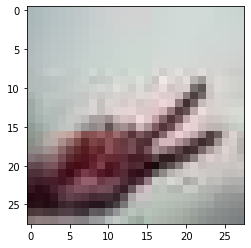

In [7]:
# Data 확인
plt.imshow(x_train[0])
print("라벨 : ", y_train[0])

In [8]:
# Model 
# layer도 추가하고 dropout도 추가를 해봤습니다.
# 층을 더 깊게 쌓는다고해서 성능이 더 좋아지는 것은 아닙니다
model=keras.models.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,3)),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax'),
])


In [9]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss ='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )
# early_stopping은 monitor를 기준으로  patience 동안만큼 나아지지 않으면 epoch을 더 돌지말고 멈추게 만드는 callback입니다.
#  val_loss가 11번동안 나아지지 않으면 학습을 멈추는 것입니다.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=11)
# shuffle은 데이터를 섞어줍니다
# callback은 위에서 만든 callback을 넣어줍니다
# validation_split은 비율만큼 validation set으로 사용합니다
model.fit(x_train, y_train,verbose=2, epochs=100, batch_size=32, shuffle=True,callbacks=[early_stopping] ,validation_split=0.3)

Epoch 1/100
79/79 - 1s - loss: 4.8070 - accuracy: 0.4675 - val_loss: 1.3637 - val_accuracy: 9.2593e-04
Epoch 2/100
79/79 - 1s - loss: 0.9604 - accuracy: 0.5202 - val_loss: 2.2483 - val_accuracy: 0.0000e+00
Epoch 3/100
79/79 - 1s - loss: 0.8875 - accuracy: 0.5472 - val_loss: 2.0113 - val_accuracy: 0.0000e+00
Epoch 4/100
79/79 - 1s - loss: 0.8513 - accuracy: 0.5865 - val_loss: 2.3089 - val_accuracy: 0.0000e+00
Epoch 5/100
79/79 - 1s - loss: 0.7799 - accuracy: 0.6452 - val_loss: 2.0345 - val_accuracy: 0.0000e+00
Epoch 6/100
79/79 - 1s - loss: 0.7341 - accuracy: 0.6754 - val_loss: 2.7620 - val_accuracy: 0.0000e+00
Epoch 7/100
79/79 - 1s - loss: 0.6844 - accuracy: 0.7067 - val_loss: 2.7961 - val_accuracy: 0.0000e+00
Epoch 8/100
79/79 - 1s - loss: 0.6160 - accuracy: 0.7365 - val_loss: 2.3764 - val_accuracy: 0.0000e+00
Epoch 9/100
79/79 - 1s - loss: 0.5974 - accuracy: 0.7440 - val_loss: 2.3185 - val_accuracy: 0.0019
Epoch 10/100
79/79 - 1s - loss: 0.5638 - accuracy: 0.7679 - val_loss: 2.5174 

In [12]:
# Test dataset 불러오기
(x_test, y_test)=load_data(image_path,False)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

테스트 데이터(x_test)의 이미지 개수는 600 입니다.
x_test shape: (600, 28, 28, 3)
y_test shape: (600,)


In [13]:
# 처참한 성능이네요... ㄷㄷ
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)

19/19 - 0s - loss: 1.1191 - accuracy: 0.3333
